In [15]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pickle
from scipy.optimize import curve_fit

In [16]:
# Define a function to deserialize the data
def deserialize(name, folder_name):
    with open(os.path.join(folder_name, name + ".pkl"), 'rb') as f:
        data = pickle.load(f, encoding='latin1', fix_imports=True)
    return data

In [17]:
train_size = 1024
test_size = 529
train_path = 'samples/train_data_f2_plain_' + str(train_size)
test_path = 'samples/test_data_f2_plain_' + str(test_size) + '/'

# Training and Testing samples
x_test, y_test = deserialize("x_test", test_path), deserialize("y_test", test_path)

In [18]:
#definition of a cost function
def mse(pred, truth):
    res = []
    for p, t in zip(pred, truth):
        res.append((p[0]-t[0])**2)
    return np.array(res)

In [19]:
archs = [(6, 1), (7, 1), (12, 1), (17, 1), (22, 1), (27, 1), (32, 1),
    (6, 2), (8, 2), (10, 2), (12, 2), (14, 2), (16, 2),
    (6, 3), (8, 3), (10, 3)]

X = x_test.detach().numpy().reshape(1, len(x_test))[0]

sampling_method = 'UNI'

if sampling_method == 'REG':
    color = 'darkolivegreen'
elif sampling_method == 'UNI':
    color = 'firebrick'
elif sampling_method == 'SOB':
    color = 'violet'

net_err = []
net_out = []
net_dist = []

for width, depth in archs:
        for state in ['plain', 'hole']:
            path = "serialized_" + state + "/serialized_data_" + sampling_method
            for test_num in range(1, 18):
                # Deserialize the data using pickle
                folder_name = path + f"_{width}_{depth}_{test_num}"
                list_names = ["mean_dist", "num_out", "output_test"]
                list_data = []
                for name in list_names:
                    list_data.append(deserialize(name, folder_name))
                mean_dist = list_data[0]
                num_out = list_data[1]
                output_test = list_data[2].detach().numpy()
                gen_err = mse(output_test, y_test)

                stack = np.column_stack((num_out, mean_dist, X, gen_err))

                if state == 'plain':
                    # create a boolean mask based on your conditions
                    mask = np.logical_or((9.5 <= stack[:, 2]) & (stack[:, 2] <= 12.5), (18.5 <= stack[:, 2]) & (stack[:, 2] <= 21.5))
                else:
                    mask = np.logical_or((11 <= stack[:, 2]) & (stack[:, 2] <= 14), (17 <= stack[:, 2]) & (stack[:, 2] <= 20))
                
                avg_err = sum(stack[mask][:, 3]) / len(stack[mask][:, 3])
                avg_out = sum(stack[mask][:, 0]) / len(stack[mask][:, 0])
                avg_dist = sum(stack[mask][:, 1]) / len(stack[mask][:, 1])
                
                net_err.append(avg_err)
                net_dist.append(avg_dist)
                net_out.append(avg_out)

Slope (a): 0.23427285385364935
Intercept (b): 2.4553904776339044
3.61889097744361 1.2581464574310297 3.3031983947048396


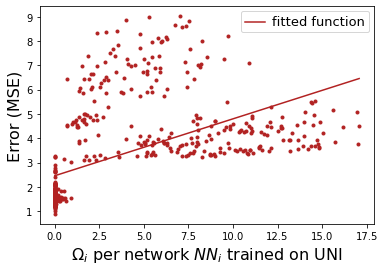

In [20]:
# calculate polynomial
z_dist = np.polyfit(net_out, net_err, 1)
f_dist = np.poly1d(z_dist)
a_dist = z_dist[0] # slope
b_dist = z_dist[1] # intercept

# print coefficients
print("Slope (a):", a_dist)
print("Intercept (b):", b_dist)

# calculate new x's and y's
x_dist = np.linspace(min(net_out), max(net_out), 100)
y_dist = f_dist(x_dist)

plt.plot(x_dist, y_dist, label="fitted function", color=color)
plt.plot(net_out, net_err, '.', color=color)

plt.xlabel(r"$\Omega_i$ per network $NN_i$ trained on "+str(sampling_method), fontsize=16)
plt.ylabel("Error (MSE)", fontsize=16)
plt.legend()

# set the font size of the "fitted function" label to 13
plt.gca().get_legend().get_texts()[0].set_fontsize(13)

plt.savefig(f"images/Comp1DOmegaNet{sampling_method}.png", dpi=100)

tot_out = sum(list(net_out)) / len(list(net_out))
tot_dist = sum(list(net_dist)) / len(list(net_dist))
tot_err = sum(list(net_err)) / len(list(net_err))
print(tot_out, tot_dist, tot_err)

Slope (a): 3.168747682168786
Intercept (b): -0.6835502761086079
3.61889097744361 1.2581464574310297 3.3031983947048396


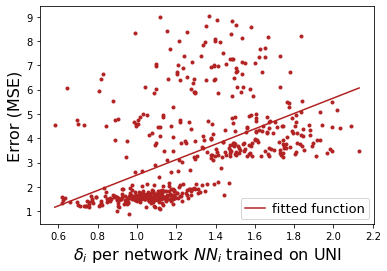

In [21]:
# calculate polynomial
z_dist = np.polyfit(net_dist, net_err, 1)
f_dist = np.poly1d(z_dist)
a_dist = z_dist[0] # slope
b_dist = z_dist[1] # intercept

# print coefficients
print("Slope (a):", a_dist)
print("Intercept (b):", b_dist)

# calculate new x's and y's
x_dist = np.linspace(min(net_dist), max(net_dist), 100)
y_dist = f_dist(x_dist)

plt.plot(x_dist, y_dist, label="fitted function", color=color)
plt.plot(net_dist, net_err, '.', color=color)

plt.xlabel(r"$\delta_i$ per network $NN_i$ trained on "+str(sampling_method), fontsize=16)
plt.ylabel("Error (MSE)", fontsize=16)
plt.legend()

# set the font size of the "fitted function" label to 13
plt.gca().get_legend().get_texts()[0].set_fontsize(13)

plt.savefig(f"images/Comp1DDeltaNet{sampling_method}.png", dpi=100)

tot_out = sum(list(net_out)) / len(list(net_out))
tot_dist = sum(list(net_dist)) / len(list(net_dist))
tot_err = sum(list(net_err)) / len(list(net_err))
print(tot_out, tot_dist, tot_err)